# QuTiP example: Nonlinear Response of the Vacuum Rabi Resonance
Akash Levy and Katie Blume

For more information about QuTiP see http://qutip.org

## Setup

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import *
from qutip.ui.progressbar import TextProgressBar as ProgressBar
qutip.settings.has_mkl = False

In [3]:
# System parameters
omega_r = 6.92E9 * 2 * np.pi            # Resonator frequency
omega_C1 = 400E6 * 2 * np.pi            # Frequency associated with charging energy of qubit 1
omega_C2 = 340E6 * 2 * np.pi            # Frequency associated with charging energy of qubit 2
omega_J = omega_r                       # Frequency associated with Josephson energy

g0_q1 = 347E6 * np.pi                   # Ground state coupling coefficient for qubit 1
g0_q2 = 94.4E6 * np.pi                  # Ground state coupling coefficient for qubit 2

swt_spot = 0
T_1_q1 = 1.4E-6 if swt_spot else 1.7E-6
T_2_q1 = 2.8E-6 if swt_spot else 0.7E-6
gamma_1 = 2 * np.pi / T_1_q1            # Rate of intrinsic relaxation of transmon excitations
gamma_phi = 0                           # Rate of pure dephasing of cavity photons (unused, ignored)
kappa = 300E3 * 2 * np.pi               # Rate of loss of cavity photons

alpha = omega_C1                        # Anharmonicity of JC ladder (to first order)

# print '{:.2e}'.format(omega_r/omega_r), '{:.2e}'.format(omega_C1/omega_r), '{:.2e}'.format(omega_J/omega_r), '{:.2e}'.format(g0_q1/omega_r), '{:.2e}'.format(gamma_1/omega_r), '{:.2e}'.format(kappa/omega_r)

In [44]:
# Dummy system parameters (for testing, comment out)
kappa = 0.01
gamma_1 = 0.01
omega_r = omega_J = 2 * np.pi
omega_C1 = 0.1 * omega_r
g0_q1 = 0.1 * 2 * np.pi
alpha = -omega_C1

# print '{:.2e}'.format(omega_r/omega_r), '{:.2e}'.format(omega_C1/omega_r), '{:.2e}'.format(omega_J/omega_r), '{:.2e}'.format(g0_q1/omega_r), '{:.2e}'.format(gamma_1/omega_r), '{:.2e}'.format(kappa/omega_r)

In [5]:
# Helper functions
def g_j(j):
    return g0_q1 * np.sqrt(j+1)
def alpha_j(j):
    return g_j(j) / g0_q1
def omega_j(j):
    return np.sqrt(8 * omega_C1 * omega_J) * (j + 1./2) - omega_C1 / 12 * (6*j**2 + 6*j + 3) - omega_J
def j_braket(j1,j2):
    if j1 >= N_atom or j2 >= N_atom:
        return tensor(qeye(N_light), identity(N_atom)-identity(N_atom))
    return tensor(qeye(N_light), fock(N_atom, j1) * fock(N_atom, j2).dag())

In [6]:
# Simulation parameters
N_light = 5
N_atom = 4

## Figure 2: Supersplitting of the vacuum Rabi resonance when probing heterodyne transmission beyond linear response

In [45]:
# Vary the driving force
xi_dbs = np.linspace(-50, -8, 43)                      # Driving strengths
omega_ds = np.linspace(0.5, 1.5, 200) * 2 * np.pi      # Driving frequencies

In [46]:
# Find transmission amplitude for varying frequencies
results = []
pbar = ProgressBar(len(xi_dbs))
for i, xi_db in enumerate(xi_dbs):
    # Convert decibel to magnitude
    xi = 10**(xi_db/20)*omega_r

    # Operators
    a = tensor(destroy(N_light), qeye(N_atom))
    sm = tensor(qeye(N_light), destroy(N_atom))
    
    # Solve master equation for different driving frequencies
    results.append([])
    for omega_d in omega_ds:
        # Hamiltonian
        H_res = (omega_r-omega_d) * a.dag() * a
        H_qub = sum([(omega_j(j)-omega_d) * j_braket(j,j) for j in range(N_atom)])
        H_int = sum([g_j(j) * (a * j_braket(j+1,j) + j_braket(j,j+1) * a.dag()) for j in range(N_atom)])
        H_drv = xi * (a.dag() + a)
        H = H_res + H_qub + H_int + H_drv

        # Collapse operators
        damping = kappa * a
        relaxation = gamma_1 * sum([alpha_j(j) * j_braket(j,j+1) for j in range(N_atom-1)])
        c_ops = [damping, relaxation]
        
        # Steady-state solution of master equation
        rho_s = steadystate(H, c_ops)
        results[-1].append(np.abs(expect(a, rho_s))**2)
    
    # Update progress bar
    pbar.update(i)

11.6%. Run time:  25.42s. Est. time left: 00:00:03:13
20.9%. Run time:  41.97s. Est. time left: 00:00:02:38
30.2%. Run time:  58.43s. Est. time left: 00:00:02:14
41.9%. Run time:  78.82s. Est. time left: 00:00:01:49
51.2%. Run time:  95.13s. Est. time left: 00:00:01:30
60.5%. Run time: 111.50s. Est. time left: 00:00:01:12
72.1%. Run time: 131.95s. Est. time left: 00:00:00:51
81.4%. Run time: 148.95s. Est. time left: 00:00:00:34
90.7%. Run time: 165.51s. Est. time left: 00:00:00:16


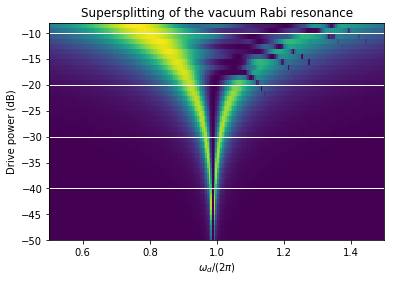

In [47]:
# Generate pseudocolor plot of transmission amplitude response over parameter space
plt.title('Supersplitting of the vacuum Rabi resonance')
plt.xlabel('$\omega_d / (2 \pi)$')
plt.ylabel('Drive power (dB)')
for i in range(-10, -50, -10):
    plt.plot(omega_ds/(2*np.pi),[i]*len(omega_ds), 'w', linewidth=1)
plt.pcolor(omega_ds/(2*np.pi), xi_dbs, results)
plt.show()

-50.0 dB


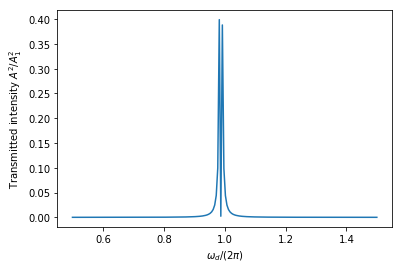

-40.0 dB


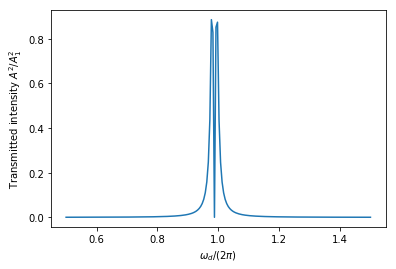

-30.0 dB


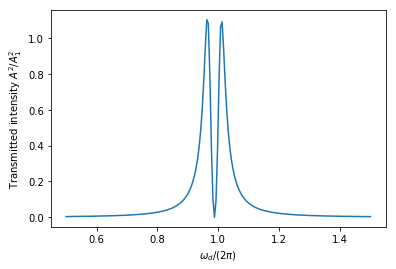

-20.0 dB


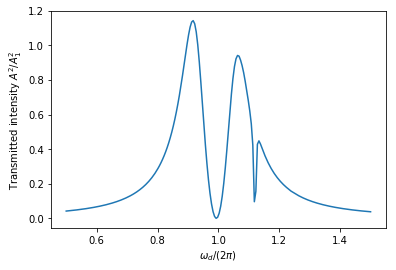

-10.0 dB


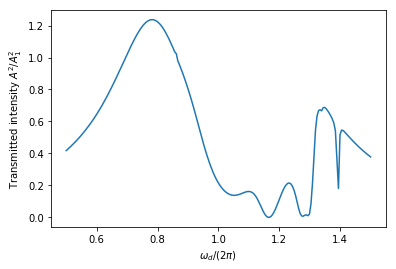

In [48]:
# Plot selected cuts
for i, xi_db in enumerate(xi_dbs):
    if int(xi_db) in range(-10, -60, -10):
        print xi_db, "dB"
        plt.xlabel('$\omega_d / (2 \pi)$')
        plt.ylabel('Transmitted intensity $A^2 / A^2_1$')
        try:
            plt.plot(omega_ds/(2*np.pi), results[i])
        except IndexError:
            plt.plot(omega_ds/(2*np.pi), results[-1])
        plt.show()

## Figure 3: Emergence of sqrt(n) peaks under strong driving of the vacuum Rabi transition

In [25]:
# Increase coupling
g0_q1 = 0.5 * 2 * np.pi

In [26]:
# Vary the driving force
xi_dbs = np.linspace(-40, -5, 36)                   # Driving strengths
omega_ds = np.linspace(0.5, 1.5, 200) * 2 * np.pi   # Driving frequencies

In [27]:
# Find transmission amplitude for varying frequencies
results = []
pbar = ProgressBar(len(xi_dbs))
for i, xi_db in enumerate(xi_dbs):
    # Convert decibel to magnitude
    xi = 10**(xi_db/20)*omega_r

    # Operators
    a = tensor(destroy(N_light), qeye(N_atom))
    sm = tensor(qeye(N_light), destroy(N_atom))
    
    # Solve master equation for different driving frequencies
    results.append([])
    for omega_d in omega_ds:
        # Hamiltonian
        H_res = (omega_r-omega_d) * a.dag() * a
        H_qub = sum([(omega_j(j)-omega_d) * j_braket(j,j) for j in range(N_atom)])
        H_int = sum([g_j(j) * (a * j_braket(j+1,j) + j_braket(j,j+1) * a.dag()) for j in range(N_atom)])
        H_drv = xi * (a.dag() + a)
        H = H_res + H_qub + H_int + H_drv

        # Collapse operators
        damping = kappa * a
        relaxation = gamma_1 * sum([alpha_j(j) * j_braket(j,j+1) for j in range(N_atom-1)])
        c_ops = [damping, relaxation]
        
        # Steady-state solution of master equation
        rho_s = steadystate(H, c_ops)
        results[-1].append(np.abs(expect(a, rho_s))**2)
    
    # Update progress bar
    pbar.update(i)

11.1%. Run time:  22.32s. Est. time left: 00:00:02:58
22.2%. Run time:  39.27s. Est. time left: 00:00:02:17
30.6%. Run time:  52.28s. Est. time left: 00:00:01:58
41.7%. Run time:  70.38s. Est. time left: 00:00:01:38
50.0%. Run time:  84.06s. Est. time left: 00:00:01:24
61.1%. Run time: 101.74s. Est. time left: 00:00:01:04
72.2%. Run time: 120.70s. Est. time left: 00:00:00:46
80.6%. Run time: 133.89s. Est. time left: 00:00:00:32
91.7%. Run time: 151.97s. Est. time left: 00:00:00:13


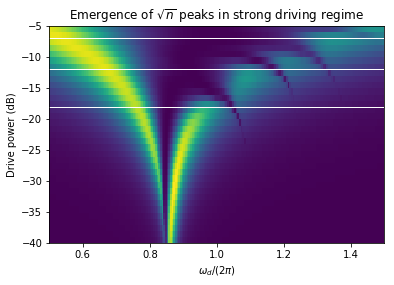

In [28]:
# Generate pseudocolor plot of transmission amplitude response over parameter space
plt.title('Emergence of $\sqrt{n}$ peaks in strong driving regime')
plt.xlabel('$\omega_d / (2 \pi)$')
plt.ylabel('Drive power (dB)')
plt.plot(omega_ds/(2*np.pi),[-18]*len(omega_ds), 'w', linewidth=1)
plt.plot(omega_ds/(2*np.pi),[-12]*len(omega_ds), 'w', linewidth=1)
plt.plot(omega_ds/(2*np.pi),[-7]*len(omega_ds), 'w', linewidth=1)
plt.pcolor(omega_ds/(2*np.pi), xi_dbs, results)
plt.show()

-18.0 dB


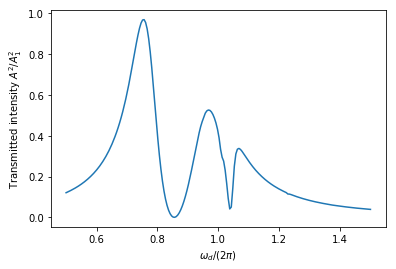

-12.0 dB


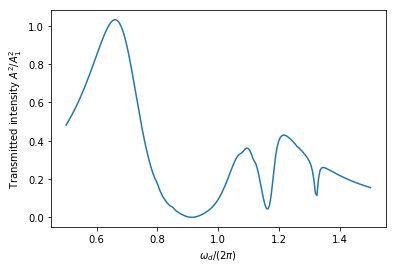

-7.0 dB


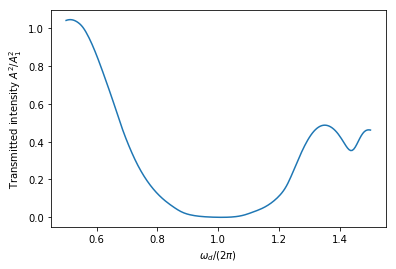

In [29]:
# Plot selected cuts
for i, xi_db in enumerate(xi_dbs):
    if int(xi_db) in [-7, -12, -18]:
        print xi_db, "dB"
        plt.xlabel('$\omega_d / (2 \pi)$')
        plt.ylabel('Transmitted intensity $A^2 / A^2_1$')
        plt.plot(omega_ds/(2*np.pi), results[i])
        plt.show()

## Versions

In [16]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,4.2.0
Numpy,1.14.3
SciPy,1.1.0
matplotlib,2.1.2
Cython,0.28.2
Number of CPUs,2
BLAS Info,OPENBLAS
IPython,5.4.1
Python,"2.7.14 |Anaconda, Inc.| (default, Dec 7 2017, 11:07:58) [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]"
OS,posix [darwin]
